In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal, LogNormal
import scipy.io as sio
import h5py

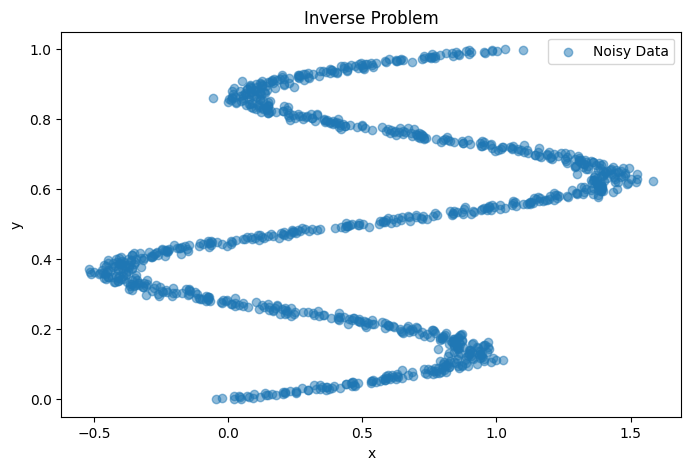

In [2]:
def data_generator():
    t = np.linspace(0, 1, 1000)
    # t = np.logspace(0.5,1,1000)  # from 1e0.5 to 1e1 seconds, 1000 points
    # Add noise (Gaussian)
    noise = np.random.normal(0, 0.05, size=t.shape)  # mean=0, std=0.05

    # Compute x using the formula
    x = t + 0.8 * np.sin(4 * np.pi * t) + noise
    return x.reshape(-1,1), t.reshape(-1,1)

x_train, y_train = data_generator()

# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, alpha=0.5, label="Noisy Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Inverse Problem")
plt.show()

In [3]:
# Define the Mixture Density Network
class MDN(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, num_gaussians=5):
        super(MDN, self).__init__()
        self.num_gaussians = num_gaussians
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.pi_layer = nn.Linear(32, num_gaussians)  # Mixing coefficients
        self.mu_layer = nn.Linear(32, num_gaussians)  # Means of Gaussians
        self.sigma_layer = nn.Linear(32, num_gaussians)  # Standard deviations
    
    def forward(self, x):
        h = self.fc(x)
        pi = torch.softmax(self.pi_layer(h), dim=1)  # Mixing coefficients (softmax)
        mu = self.mu_layer(h)  # Means
        sigma =  torch.exp(self.sigma_layer(h)).clamp(min=0.005)  # Standard deviations (exp for positivity)
        return pi, mu, sigma



In [4]:
# Define the Negative Log Likelihood loss for MDN
def mdn_loss(pi, mu, sigma, y, disttype = "Normal"):
    y = y.expand(-1, mu.shape[-1])  # Fix dimension expansion
    if disttype == "Normal":
        normal_dist = Normal(mu, sigma)
        likelihoods = torch.exp(normal_dist.log_prob(y))  # Due to numerical instability we first take a log and then exp
    else:
        log_normal_dist = LogNormal(mu, sigma)
        likelihoods = torch.exp(log_normal_dist.log_prob(y))
    weighted_likelihoods = pi * likelihoods  # Weight by mixing coefficients
    loss = -torch.log(weighted_likelihoods.sum(dim=1) + 1e-8).mean()  # Log sum exp trick
    return loss

In [13]:
# Training the model
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

sample_model = MDN(1,1,10)
optimizer = optim.Adam(sample_model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = sample_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

C:\Users\ehsan010\AppData\Local\Temp\ipykernel_16468\533927871.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
C:\Users\ehsan010\AppData\Local\Temp\ipykernel_16468\533927871.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


Epoch 0, Loss: 1.0892
Epoch 50, Loss: 0.0345
Epoch 100, Loss: -0.2866
Epoch 150, Loss: -0.7305
Epoch 200, Loss: -1.1269
Epoch 250, Loss: -1.0555
Epoch 300, Loss: -0.6066
Epoch 350, Loss: -1.4913
Epoch 400, Loss: -0.9091
Epoch 450, Loss: -1.2758
Epoch 500, Loss: -1.6022
Epoch 550, Loss: -1.0681
Epoch 600, Loss: -1.6621
Epoch 650, Loss: -1.7798
Epoch 700, Loss: -1.4882
Epoch 750, Loss: -1.8309
Epoch 800, Loss: -1.7364
Epoch 850, Loss: -2.0298
Epoch 900, Loss: -2.1317
Epoch 950, Loss: -2.0563
Epoch 1000, Loss: -2.0871
Epoch 1050, Loss: -2.0642
Epoch 1100, Loss: -1.8916
Epoch 1150, Loss: -1.9898
Epoch 1200, Loss: -2.1767
Epoch 1250, Loss: -2.0563
Epoch 1300, Loss: -2.1524
Epoch 1350, Loss: -2.0359
Epoch 1400, Loss: -2.1650
Epoch 1450, Loss: -2.1896
Epoch 1500, Loss: -2.1761
Epoch 1550, Loss: -2.1913
Epoch 1600, Loss: -2.1676
Epoch 1650, Loss: -2.1991
Epoch 1700, Loss: -2.1480
Epoch 1750, Loss: -2.1881
Epoch 1800, Loss: -2.2034
Epoch 1850, Loss: -2.1858
Epoch 1900, Loss: -2.1182
Epoch 1950,

In [14]:
# Final PDF calculation function (same as before)
def final_pdf(pi, mu, sigma, x, disttype="Normal"):
    pdf_values = torch.zeros(x.shape[0], pi.shape[1])  # [1000, 5]
    
    # Compute the individual PDF values for each Gaussian component
    for i in range(pi.shape[1]):  # num_gaussians
        if disttype=="Normal":
            dist = Normal(mu[:, i], sigma[:, i])
            pdf_values[:, i] = dist.log_prob(x).exp()  # Exponentiate to get the actual PDF
        else:
            dist = LogNormal(mu[:, i], sigma[:, i])
            pdf_values[:, i] = dist.log_prob(x).exp()  # Exponentiate to get the actual PDF
    
    # Weight the PDFs by the mixing coefficients (pi)
    weighted_pdf = pdf_values * pi  # Broadcasting pi across [1000, 5]
    
    # Sum the weighted PDFs over all components
    final_pdf_values = weighted_pdf.sum(dim=1)  
    # for Nomral torch.trapz(final_pdf_values, x) must be 1
    # for LogNormal torch.trapz(final_pdf_values, x) must be 1
    return final_pdf_values

# Sampling from the combined PDF based on the learned model parameters
def sample_from_combined_pdf(pi, mu, sigma, num_samples=100, disttype="Normal"):
    # print(num_samples)
    """
    Sample 'num_samples' values from the final combined distribution using the CDF.
    
    pi: mixing coefficients (5 values)
    mu: means of the 5 Gaussians
    sigma: standard deviations of the 5 Gaussians
    num_samples: number of samples to generate (default is 100)
    """
    if disttype=="Normal":
        x_values = torch.linspace(-10, 10, steps=1000)  # Define the range for sampling
    else:
        x_values = torch.logspace(-5, 5, steps=1000)  # Define the range for sampling

    
    pdf_values = final_pdf(pi, mu, sigma, x_values, disttype)  # Compute the PDF
    
    # Normalize the PDF to get the CDF
    cdf_values = torch.cumsum(pdf_values, dim=0)
    cdf_values = cdf_values / cdf_values[-1]  # Normalize so that CDF ends at 1
    
    # Generate 'num_samples' random values to sample from the CDF
    u = torch.rand(num_samples)  # Generate random values to sample from the CDF
    
    samples = []
    for val in u:
        sample_index = (cdf_values > val).nonzero(as_tuple=True)[0][0].item()
        sample = x_values[sample_index]
        samples.append(sample)
    
    return torch.tensor(samples)



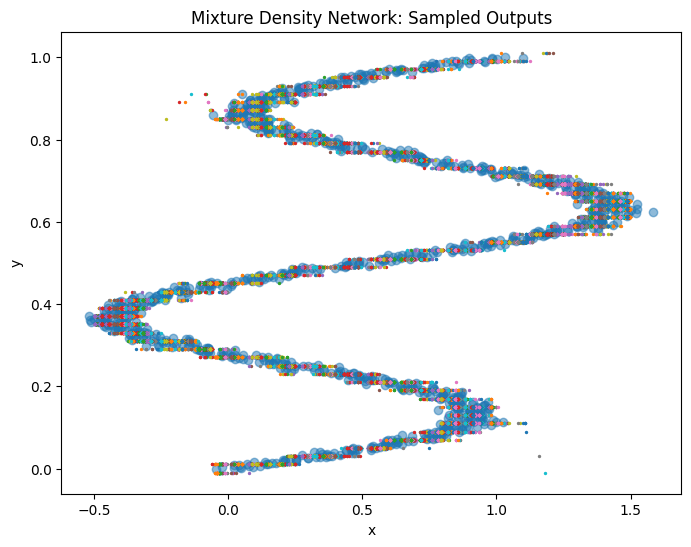

In [15]:
# Example usage:
x_test = torch.rand(500, 1)*2-0.5  # 500 values of x_test (batch of 500)
pi, mu, sigma = sample_model(x_test)  # Get the corresponding pi, mu, sigma

# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

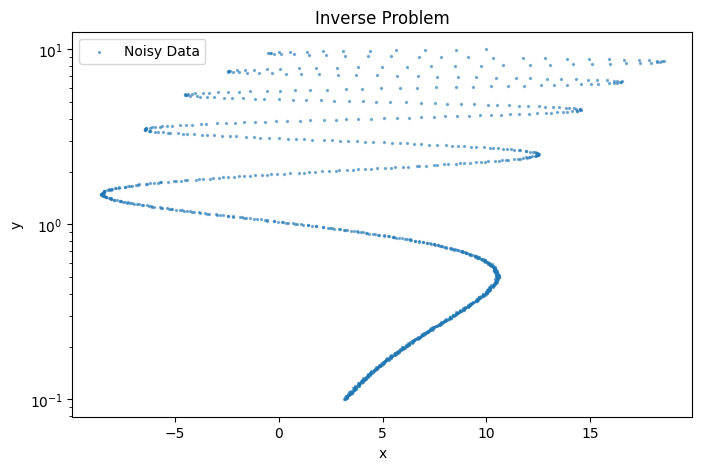

In [23]:
def data_generator():
    # t = np.linspace(0, 1, 1000)
    t = np.logspace(-1,1,1000)  # from 1e0.5 to 1e1 seconds, 1000 points
    # Add noise (Gaussian)
    noise = np.random.normal(0, 0.05, size=t.shape)  # mean=0, std=0.05

    # Compute x using the formula
    x = t + 10 * np.sin(1 * np.pi * t) + noise
    return x.reshape(-1,1), t.reshape(-1,1)

x_train, y_train = data_generator()

# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, alpha=0.5, label="Noisy Data",s=2)
plt.xlabel("x")
plt.ylabel("y")
plt.yscale('log')
plt.legend()
plt.title("Inverse Problem")
plt.show()

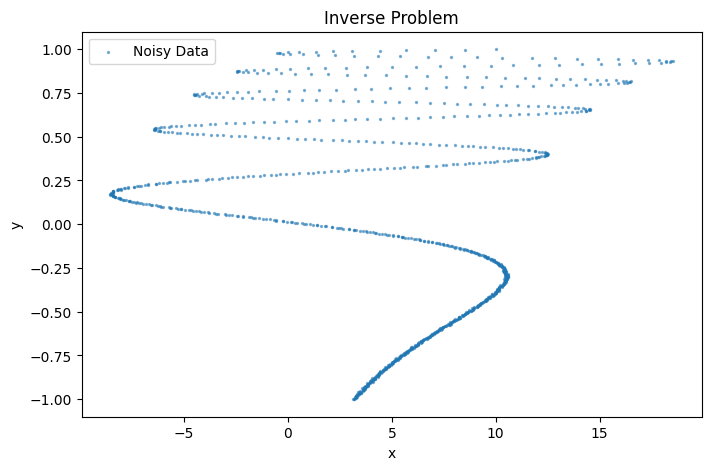

In [24]:
# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, np.log10(y_train), alpha=0.5, label="Noisy Data",s=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Inverse Problem")
plt.show()

In [25]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(np.log(y_train), dtype=torch.float32)

sample_model_log = MDN(1,1,100)
optimizer = optim.Adam(sample_model_log.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = sample_model_log(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.8053
Epoch 50, Loss: 1.1261
Epoch 100, Loss: 0.5973
Epoch 150, Loss: 1.2505
Epoch 200, Loss: 0.5109
Epoch 250, Loss: -0.1464
Epoch 300, Loss: -0.0981
Epoch 350, Loss: -0.1112
Epoch 400, Loss: 0.3965
Epoch 450, Loss: -0.2816
Epoch 500, Loss: -0.2847
Epoch 550, Loss: -0.2510
Epoch 600, Loss: 0.2464
Epoch 650, Loss: -0.7210
Epoch 700, Loss: -0.5343
Epoch 750, Loss: 1.5039
Epoch 800, Loss: -0.5661
Epoch 850, Loss: -0.2355
Epoch 900, Loss: -1.0118
Epoch 950, Loss: 0.4744
Epoch 1000, Loss: 0.3401
Epoch 1050, Loss: -1.1987
Epoch 1100, Loss: -0.9527
Epoch 1150, Loss: -0.4126
Epoch 1200, Loss: -1.2751
Epoch 1250, Loss: -0.9988
Epoch 1300, Loss: -1.2769
Epoch 1350, Loss: -0.8176
Epoch 1400, Loss: -0.9511
Epoch 1450, Loss: -1.0414
Epoch 1500, Loss: -0.9845
Epoch 1550, Loss: -1.0846
Epoch 1600, Loss: -1.3484
Epoch 1650, Loss: -1.6118
Epoch 1700, Loss: -1.4052
Epoch 1750, Loss: -0.7151
Epoch 1800, Loss: 0.1531
Epoch 1850, Loss: -0.2251
Epoch 1900, Loss: -1.5552
Epoch 1950, Loss: -1

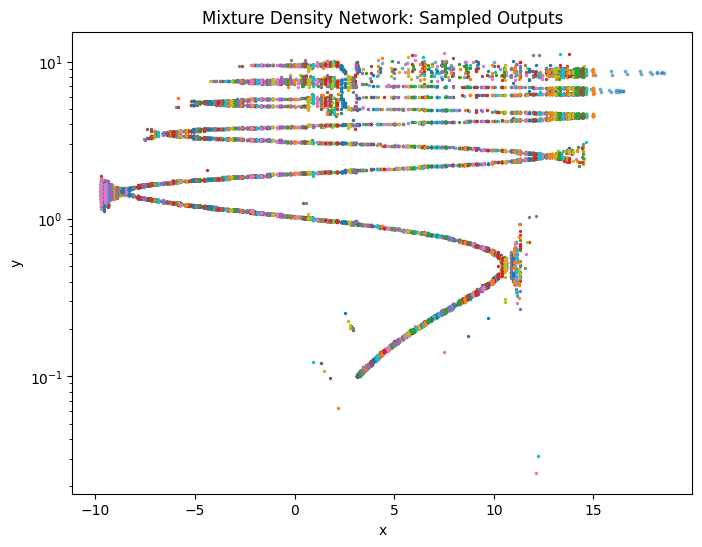

In [26]:
# Example usage:
x_test = torch.rand(500, 1)*25-10  # 500 values of x_test (batch of 500)
pi, mu, sigma = sample_model_log(x_test)  # Get the corresponding pi, mu, sigma

# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), np.exp(y_train.numpy()), alpha=0.5, label='Training Data',s=3)

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), np.exp(y_s), s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.yscale('log')
plt.show()

In [27]:
HotWireWT7 = h5py.File(r'SGFV_param_HotWT7_short.mat','r')
T_domain_WT7 = np.array(HotWireWT7.get('T_domain_WT7')).T
X_domain_WT7 = np.array(HotWireWT7.get('X_domain_WT7')).T
res_WT7 = np.array(HotWireWT7.get('res_WT7'))

VF_HotWT7 = HotWireWT7['VF_HotWT7']
VF_HotWT7_u_tau = VF_HotWT7['u_tau'][0]


duNN_refs = HotWireWT7['duNN_HotWT7']
maxmin_pairs_cell_HotWT7_refs = HotWireWT7['value_pairs_cell_HotWT7']
duwrtlocalmaxmin_HotWT7_refs = HotWireWT7['duwrtlocalmaxmin_HotWT7']

# To dereference:
duNN_HotWT7_list = []

for ref in duNN_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        duNN_HotWT7_list.append(array_data)

duwrtlocalmaxmin_HotWT7_list = []

for ref in duwrtlocalmaxmin_HotWT7_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        duwrtlocalmaxmin_HotWT7_list.append(array_data)

maxmin_pairs_HotWT7_list = []

for ref in maxmin_pairs_cell_HotWT7_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        maxmin_pairs_HotWT7_list.append(array_data)


min_values = maxmin_pairs_HotWT7_list[0][1]/VF_HotWT7_u_tau
max_values = maxmin_pairs_HotWT7_list[0][0]/VF_HotWT7_u_tau

In [22]:
Given_min_model = MDN(1,1,5)
optimizer = optim.Adam(Given_min_model.parameters(), lr=0.01)

x_train = torch.tensor(min_values.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(max_values.reshape(-1,1), dtype=torch.float32)

In [23]:
# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_min_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.2254
Epoch 50, Loss: 0.8036
Epoch 100, Loss: 0.5979
Epoch 150, Loss: 0.5854
Epoch 200, Loss: 0.5584
Epoch 250, Loss: 0.5574
Epoch 300, Loss: 0.5823
Epoch 350, Loss: 0.5812
Epoch 400, Loss: 0.5582
Epoch 450, Loss: 0.5627
Epoch 500, Loss: 0.5384
Epoch 550, Loss: 0.5586
Epoch 600, Loss: 0.5636
Epoch 650, Loss: 0.6051
Epoch 700, Loss: 0.5351
Epoch 750, Loss: 0.5689
Epoch 800, Loss: 0.5383
Epoch 850, Loss: 0.5387
Epoch 900, Loss: 0.5464
Epoch 950, Loss: 0.5359
Epoch 1000, Loss: 0.5664
Epoch 1050, Loss: 0.5399
Epoch 1100, Loss: 0.5517
Epoch 1150, Loss: 0.5637
Epoch 1200, Loss: 0.5562
Epoch 1250, Loss: 0.5422
Epoch 1300, Loss: 0.5569
Epoch 1350, Loss: 0.5404
Epoch 1400, Loss: 0.5314
Epoch 1450, Loss: 0.5324
Epoch 1500, Loss: 0.5514
Epoch 1550, Loss: 0.5324
Epoch 1600, Loss: 0.5518
Epoch 1650, Loss: 0.5310
Epoch 1700, Loss: 0.5299
Epoch 1750, Loss: 0.5327
Epoch 1800, Loss: 0.5529
Epoch 1850, Loss: 0.5343
Epoch 1900, Loss: 0.5264
Epoch 1950, Loss: 0.5414
Epoch 2000, Loss: 0.532

In [ ]:
'''If we want do inferencing'''
Given_min_model.load_state_dict(torch.load('G:\My Drive\Research\VFfeaturedVorX\Given_min_model_short.pth'))
Given_min_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

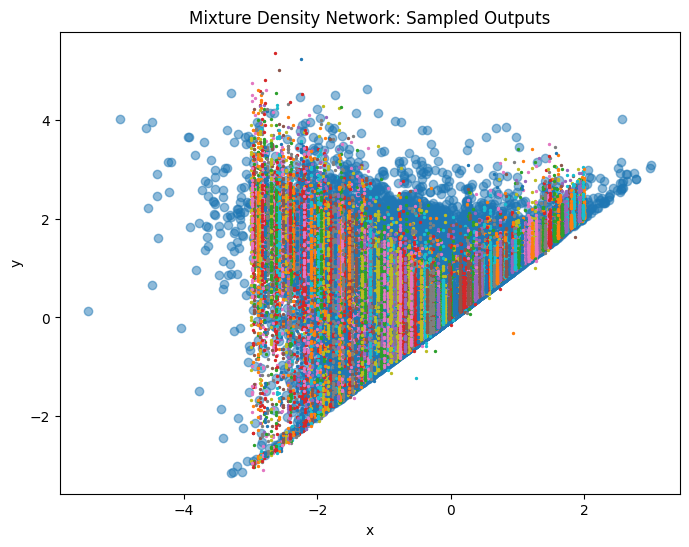

In [27]:
x_test = torch.rand(500, 1)*5-3.0
pi, mu, sigma = Given_min_model(x_test)


# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [28]:
# Saving the trained model
torch.save(Given_min_model.state_dict(), 'Given_min_model_short.pth')

In [29]:
Given_max_model = MDN(1,1,5)
optimizer = optim.Adam(Given_max_model.parameters(), lr=0.01)

x_train = torch.tensor(max_values.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(min_values.reshape(-1,1), dtype=torch.float32)

In [30]:
# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_max_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 1.2156
Epoch 50, Loss: 0.6607
Epoch 100, Loss: 0.7337
Epoch 150, Loss: 0.6141
Epoch 200, Loss: 0.5979
Epoch 250, Loss: 0.5820
Epoch 300, Loss: 0.5747
Epoch 350, Loss: 0.5619
Epoch 400, Loss: 0.5415
Epoch 450, Loss: 0.5599
Epoch 500, Loss: 0.5433
Epoch 550, Loss: 0.5470
Epoch 600, Loss: 0.5422
Epoch 650, Loss: 0.5482
Epoch 700, Loss: 0.5408
Epoch 750, Loss: 0.5345
Epoch 800, Loss: 0.5363
Epoch 850, Loss: 0.5353
Epoch 900, Loss: 0.5642
Epoch 950, Loss: 0.5225
Epoch 1000, Loss: 0.5268
Epoch 1050, Loss: 0.5279
Epoch 1100, Loss: 0.5499
Epoch 1150, Loss: 0.5241
Epoch 1200, Loss: 0.5213
Epoch 1250, Loss: 0.5353
Epoch 1300, Loss: 0.5434
Epoch 1350, Loss: 0.5336
Epoch 1400, Loss: 0.5234
Epoch 1450, Loss: 0.5270
Epoch 1500, Loss: 0.5261
Epoch 1550, Loss: 0.5219
Epoch 1600, Loss: 0.5136
Epoch 1650, Loss: 0.5144
Epoch 1700, Loss: 0.5271
Epoch 1750, Loss: 0.5171
Epoch 1800, Loss: 0.5344
Epoch 1850, Loss: 0.5427
Epoch 1900, Loss: 0.5157
Epoch 1950, Loss: 0.5237
Epoch 2000, Loss: 0.519

In [ ]:
'''If we want do inferencing'''
Given_max_model.load_state_dict(torch.load('G:\My Drive\Research\VFfeaturedVorX\Given_max_model_short.pth'))
Given_max_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

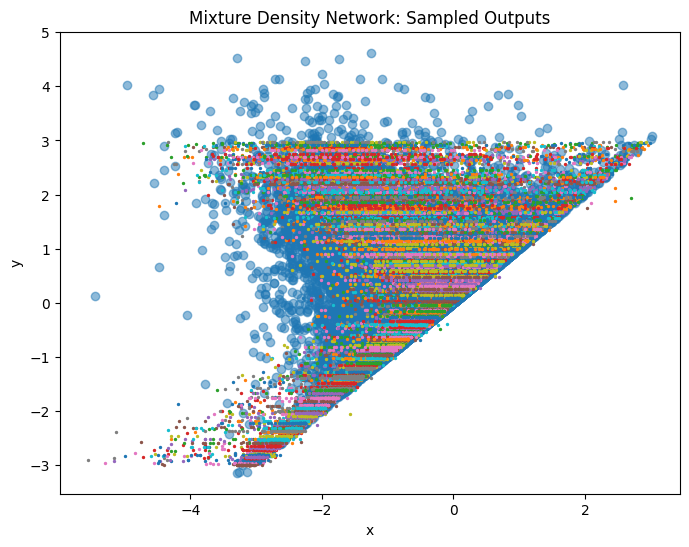

In [32]:
x_test = torch.rand(500, 1)*6-3.0
pi, mu, sigma = Given_max_model(x_test)
# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(y_train.numpy(),x_train.numpy() , alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(y_s, np.repeat(x_test[i].numpy(), num_samples), s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [33]:
# Saving the trained model
torch.save(Given_max_model.state_dict(), 'Given_max_model_short.pth')

In [28]:
duwrtlocalmaxmin_HotWT7 = duwrtlocalmaxmin_HotWT7_list[0]/VF_HotWT7_u_tau
duNN_HotWT7 = duNN_HotWT7_list[0]/(VF_HotWT7_u_tau*res_WT7[0,0])



x_train = torch.tensor(duwrtlocalmaxmin_HotWT7.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(duNN_HotWT7.reshape(-1,1), dtype=torch.float32)




# nonzero_mask = (y_train != 0).squeeze()

# # # Filter both x_train and y_train using the mask
# x_train = x_train[nonzero_mask]
# y_train= y_train[nonzero_mask]

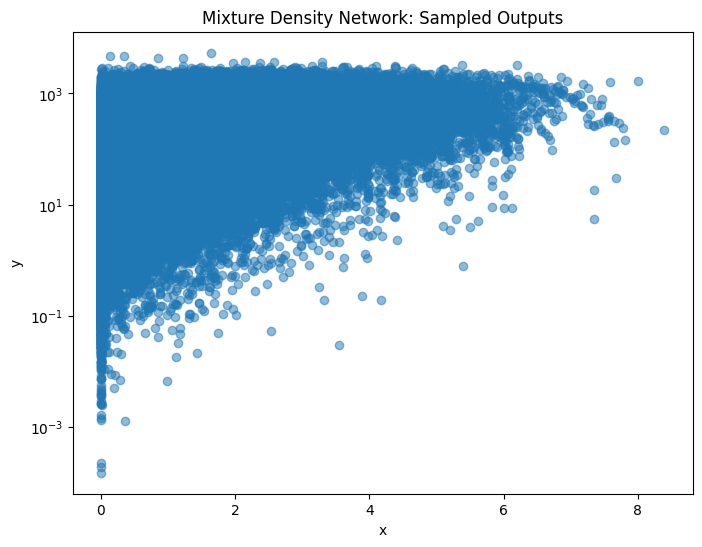

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')
plt.yscale('log')
plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

C:\Users\ehsan010\AppData\Local\Temp\ipykernel_16468\1953867521.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x_train.numpy(), np.log(y_train.numpy()), alpha=0.5, label='Training Data')


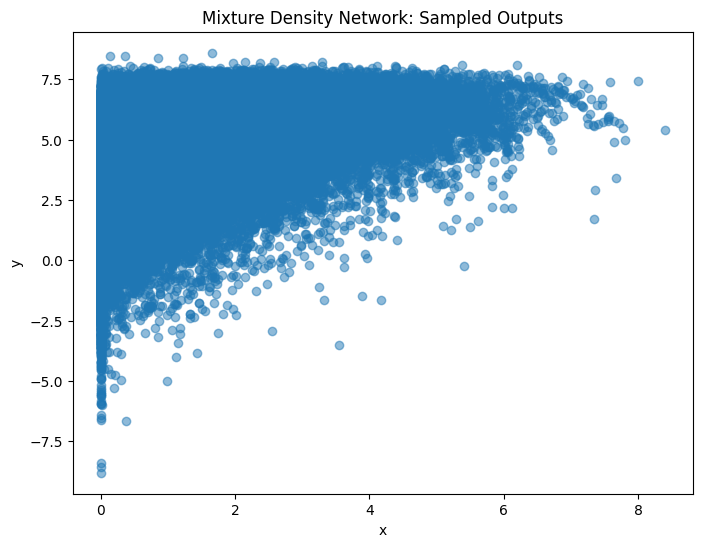

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), np.log(y_train.numpy()), alpha=0.5, label='Training Data')
plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [32]:
Given_dist_NLmin_NLmax_model = MDN(1,1,5)
optimizer = optim.Adam(Given_dist_NLmin_NLmax_model.parameters(), lr=0.01)

x_train = torch.tensor(duwrtlocalmaxmin_HotWT7.reshape(-1,1), dtype=torch.float32)
y_train = torch.log(torch.tensor(duNN_HotWT7.reshape(-1,1), dtype=torch.float32)+1e-10)
# Training loopl
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_dist_NLmin_NLmax_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 11.4730
Epoch 50, Loss: 1.6358
Epoch 100, Loss: 1.3253
Epoch 150, Loss: 1.2684
Epoch 200, Loss: 1.2576
Epoch 250, Loss: 1.2597
Epoch 300, Loss: 1.2460
Epoch 350, Loss: 1.2403
Epoch 400, Loss: 1.2412
Epoch 450, Loss: 1.2352
Epoch 500, Loss: 1.2344
Epoch 550, Loss: 1.2285
Epoch 600, Loss: 1.2250
Epoch 650, Loss: 1.2227
Epoch 700, Loss: 1.2248
Epoch 750, Loss: 1.2207
Epoch 800, Loss: 1.2190
Epoch 850, Loss: 1.2182
Epoch 900, Loss: 1.2130
Epoch 950, Loss: 1.2128
Epoch 1000, Loss: 1.2396
Epoch 1050, Loss: 1.2161
Epoch 1100, Loss: 1.2163
Epoch 1150, Loss: 1.2220
Epoch 1200, Loss: 1.2146
Epoch 1250, Loss: 1.2130
Epoch 1300, Loss: 1.2157
Epoch 1350, Loss: 1.2115
Epoch 1400, Loss: 1.2005
Epoch 1450, Loss: 1.2167
Epoch 1500, Loss: 1.1927
Epoch 1550, Loss: 1.2348
Epoch 1600, Loss: 1.1904
Epoch 1650, Loss: 1.1892
Epoch 1700, Loss: 1.2009
Epoch 1750, Loss: 1.2175
Epoch 1800, Loss: 1.1986
Epoch 1850, Loss: 1.2460
Epoch 1900, Loss: 1.1934
Epoch 1950, Loss: 1.1844
Epoch 2000, Loss: 1.19

In [ ]:
'''If we want do inferencing'''
Given_dist_NLmin_NLmax_model.load_state_dict(torch.load('G:\My Drive\Research\VFfeaturedVorX\Given_dist_NLmin_NLmax_model_short.pth'))
Given_dist_NLmin_NLmax_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

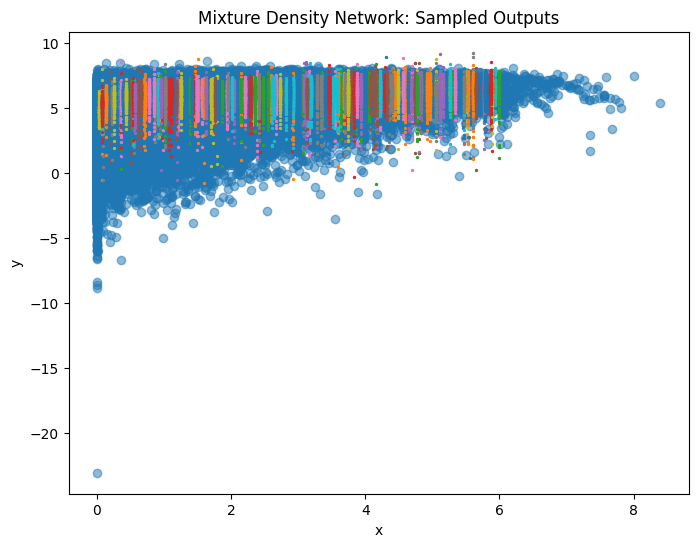

In [33]:
x_test = torch.rand(200, 1)*6
pi, mu, sigma = Given_dist_NLmin_NLmax_model(x_test)


# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 100  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

# plt.yscale('log')
plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [34]:
# Saving the trained model
torch.save(Given_dist_NLmin_NLmax_model.state_dict(), 'Given_dist_NLmin_NLmax_model_short.pth')